In [35]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import os

from typing import Tuple, Any
import numpy.typing as npt

plt.style.use(['science', 'ieee', 'no-latex'])

In [36]:
NA = 0.86
LAMBDA = 248
K = 2 * np.pi / np.float64(LAMBDA)
R = NA / np.float64(LAMBDA)
W = 200
THESHOLD = 0.5

# target_path = './img_test/sources_2D/'
# os.system(f'rm -rf {target_path}')
# if not os.path.isdir(target_path):
#     os.makedirs(target_path)

```
Choose Simulation Mode
    - A
        - s_max: 500
        - samp: 21
        - delta_f: 0.001
    - B
        - s_max: 5000
        - samp: 201
        - delta_f: 0.0001
    - C
        - s_max: 500
        - samp: 2001
        - delta_f: 0.00001
```

In [37]:
f_max = 0.02
s_max, samp, delta_f, delta_s = 500, 101, 0.001, 10
# mode = input('Choose Simulation Mode (A, B, C): ')
# match mode:
#     case 'A':
#         s_max, samp, delta_f = 500, 41, 0.001
#     case 'B':
#         s_max, samp, delta_f = 5000, 401, 0.0001
#     case 'C':
#         s_max, samp, delta_f = 50000, 4001, 0.00001
#     case _:
#         pass
# delta_s = 25

s_max, samp, delta_f, delta_s

(500, 101, 0.001, 10)

In [38]:
def space_freq_transformation(
    s_max: int, f_max: float, samp: int
) -> Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    """
    Parameters
    ----------
    s_max : int
        The size of the spatial coordinate
    f_max : float
        The size of the frequency coordinate
    samp : int
        The number of sampling points
        
    Returns
    ----------
    s_space : array_like
        Return a 1D spatial space for future use
    f_space : array_like
        Return a 1D frequency space for future use
    """
    s_space = np.linspace(-s_max, s_max, samp, dtype=np.float64)
    f_space = np.linspace(-f_max, f_max, samp, dtype=np.float64)
    return s_space, f_space

In [39]:
source_samp = None
mode = input('Number of sources (A: 4, B: 8, C: 16, D: 32, E: 64)')
match mode:
    case 'A':
        source_samp = 2 * 4 + 1
    case 'B':
        source_samp = 2 * 8 + 1
    case 'C':
        source_samp = 2 * 16 + 1
    case 'D':
        source_samp = 2 * 32 + 1
    case 'E':
        source_samp = 2 * 32 + 1
    case _:
        source_samp = 2 * 4 + 1

source_samp

65

In [40]:
def source_seq(NA: float, source_samp: int) -> npt.NDArray[np.float64]:
    """
    Parameters
    ----------
    NA : floati
        The size of the sin value source-space 
    source_samp : int
        The number of the sampling points
    Returns
    ----------
    sin_space : array_like
        The space of sin value
    """
    sin_space = np.linspace(-NA, NA, source_samp, dtype=np.float64)
    return sin_space

In [41]:
# space and freq
s_space, f_space = space_freq_transformation(s_max, f_max, samp)
xx_space, yy_space = np.meshgrid(s_space, s_space)
x_space, y_space = xx_space.flatten(), yy_space.flatten()
xx_freq, yy_freq = np.meshgrid(f_space, f_space)
x_freq, y_freq = xx_freq.flatten(), yy_freq.flatten()
# source
sin_space = source_seq(NA, source_samp)
xx_sin, yy_sin = np.meshgrid(sin_space, sin_space)
x_sin, y_sin = xx_sin.flatten(), yy_sin.flatten()
# I_dist
r, c = x_space.shape[0], x_sin.shape[0]
I_dist = np.ones(shape=(r, c))

In [42]:
def generate_Ein(
    x: npt.NDArray[np.float64],
    sinx: np.float64,
    y: npt.NDArray[np.float64],
    siny: np.float64,
    magnitude: int = 1
) -> npt.NDArray[np.float64]:
    return magnitude * np.exp(1j * K * (x * sinx + y * siny))

In [43]:
def fourier_transform(
    arr: npt.NDArray[np.float64]
) -> npt.NDArray[np.float64]:
    return np.fft.fft2(arr)

In [44]:
def shift2D(arr: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
    N = (arr.shape[0] - 1) // 2
    new_arr = np.zeros_like(arr)
    new_arr[N + 1:, N + 1:] = arr[:N, :N]
    new_arr[N + 1:, :N + 1] = arr[:N, N:]
    new_arr[:N + 1, :N + 1] = arr[N:, N:]
    new_arr[:N + 1, N + 1:] = arr[N:, :N]
    return new_arr

In [45]:
def generate_pupil(
    xx_freq: npt.NDArray[np.float64], 
    yy_freq: npt.NDArray[np.float64],
    R: np.float64
) -> npt.NDArray[np.int64]:
    R_square = R ** 2
    ret_freq = xx_freq ** 2 + yy_freq ** 2
    ret_freq = np.where(np.abs(ret_freq) <= R_square, 1, 0)
    return ret_freq

pupil = generate_pupil(xx_freq, yy_freq, R)

In [46]:
def inv_fourier_transform(
    arr: npt.NDArray[np.float64]
) -> npt.NDArray[np.float64]:
    return np.fft.ifft2(arr)

In [47]:
def generate_square_mask(
    s_space: npt.NDArray[np.float64],
    W: int
) -> npt.NDArray[np.int64]:
    s_mask = np.where(np.abs(s_space) <= W, 1, 0)
    xx, yy = np.meshgrid(s_mask, s_mask)
    ret = xx ** 2 + yy ** 2
    return ret

In [48]:
# mask
square_mask = generate_square_mask(s_space, W)
square_mask.shape

(101, 101)

In [49]:
cnt = 0
for sinx, siny in zip(x_sin, y_sin):
    # generate 2D Ein
    E_in = generate_Ein(xx_space, sinx, yy_space, siny)
    # Ein and the mask
    E_in_mask = E_in * square_mask
    # get E_out_unshift
    E_out_unshift = fourier_transform(E_in_mask)
    # E_out_pupil
    E_out_shift = shift2D(E_out_unshift)
    # E_out_pupil
    E_out_pupil = E_out_shift * pupil
    # E_out_pupil_unshift
    E_out_pupil_unshift = shift2D(E_out_pupil)
    # get I
    I = inv_fourier_transform(E_out_pupil_unshift)
    I_abs = np.abs(I) ** 2
    I_abs_colv = I_abs.flatten()
    # put into I_dist
    I_dist[:, cnt] = I_abs_colv
    # add 1 for increase the index number of column
    cnt += 1

In [50]:
open_source = np.ones(shape=(I_dist.shape[1]), dtype=int)
normalize = open_source.shape[0] * (2 * W // delta_s + 1) 
I_out = np.dot(I_dist, open_source) / normalize

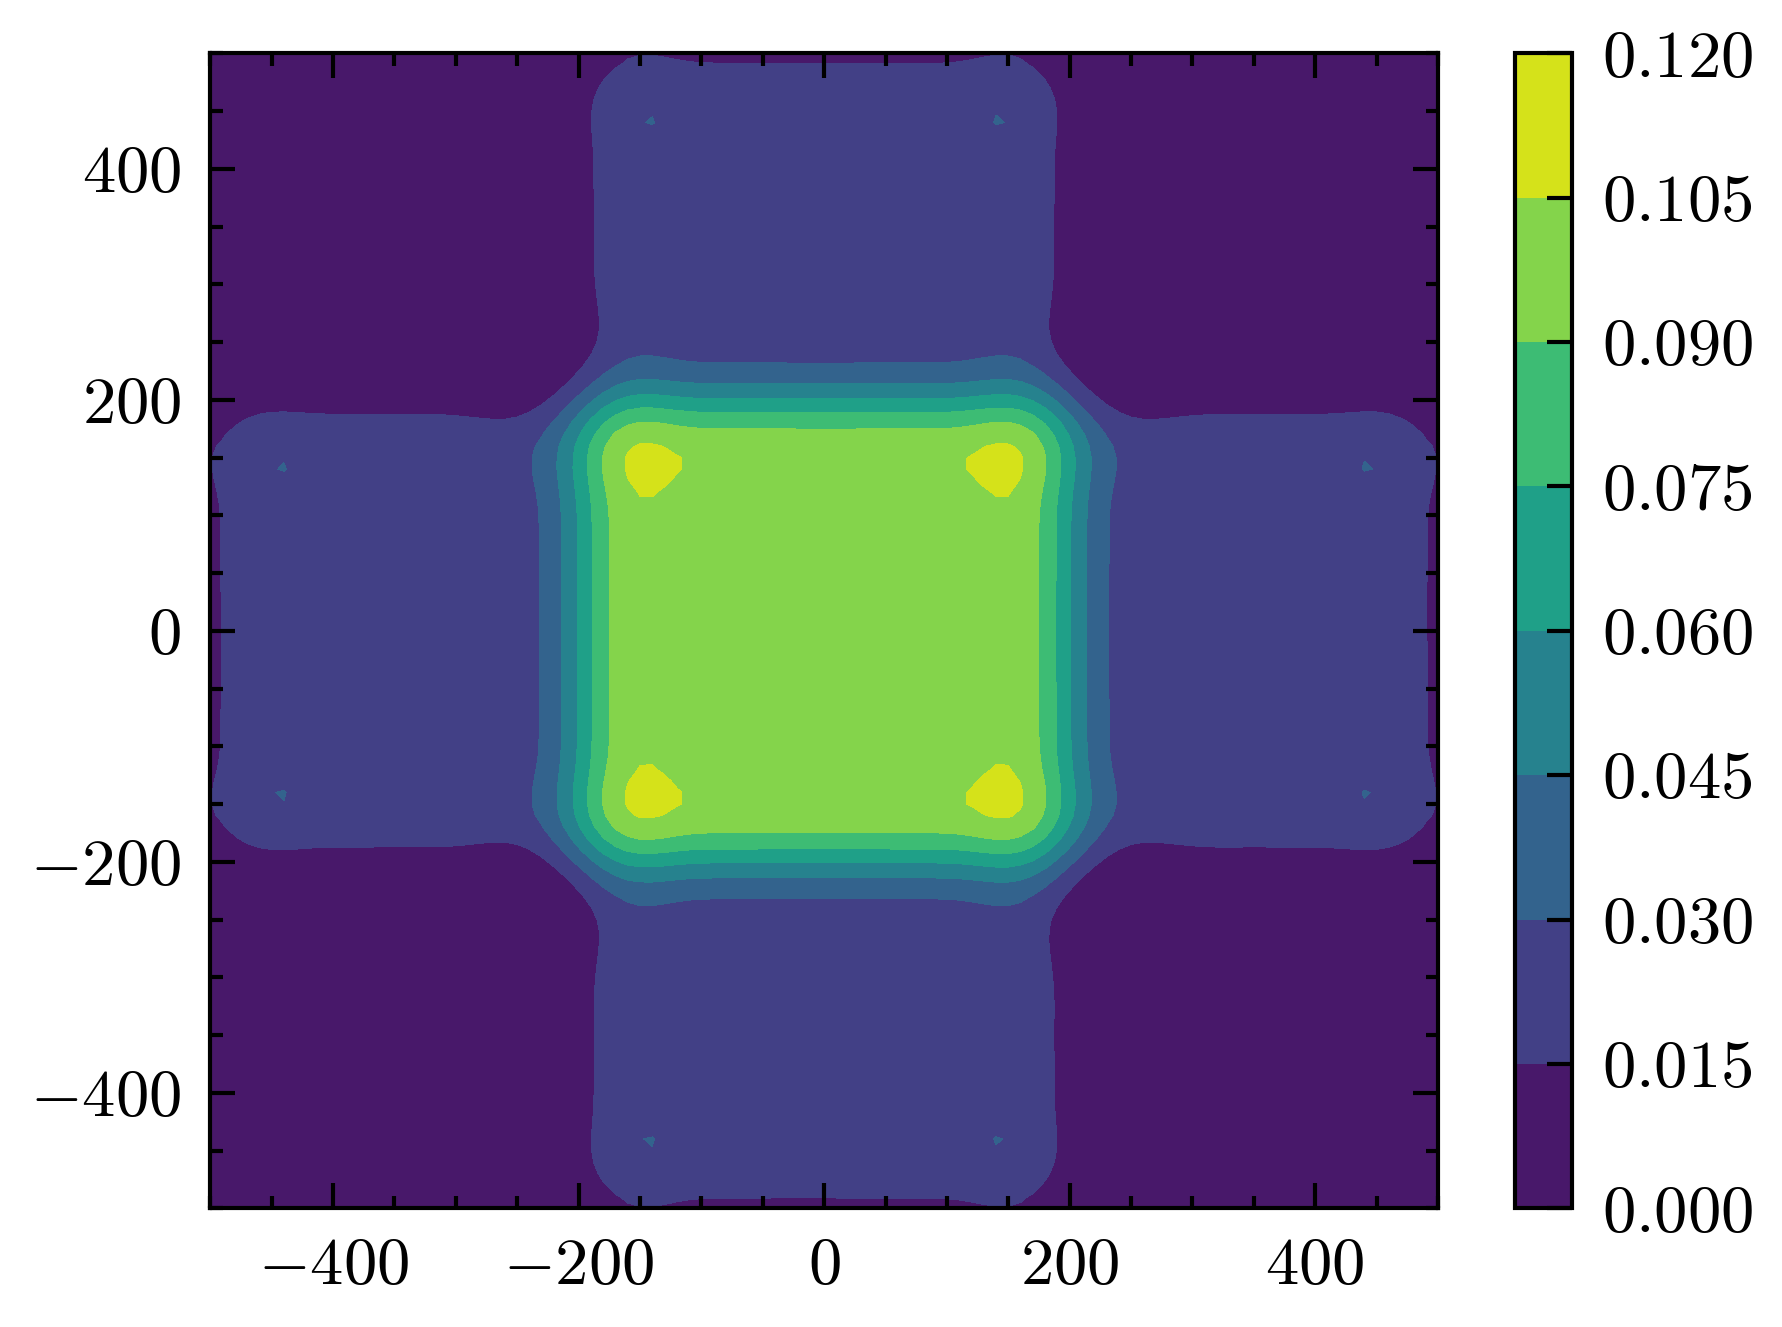

In [51]:
I_out_dist_2D = np.reshape(I_out, xx_space.shape)
plt.contourf(xx_space, yy_space, I_out_dist_2D)
# plt.contour(xx_space, yy_space, I_out_dist_2D)
plt.colorbar()